# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df = df.resample('1H').sum()

## Analysis

<AxesSubplot:xlabel='datetime'>

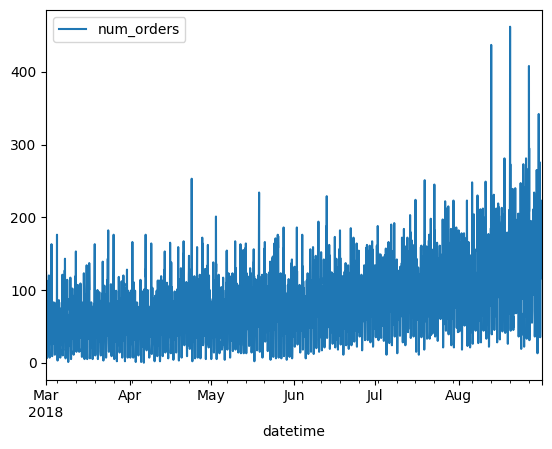

In [6]:
df.plot()

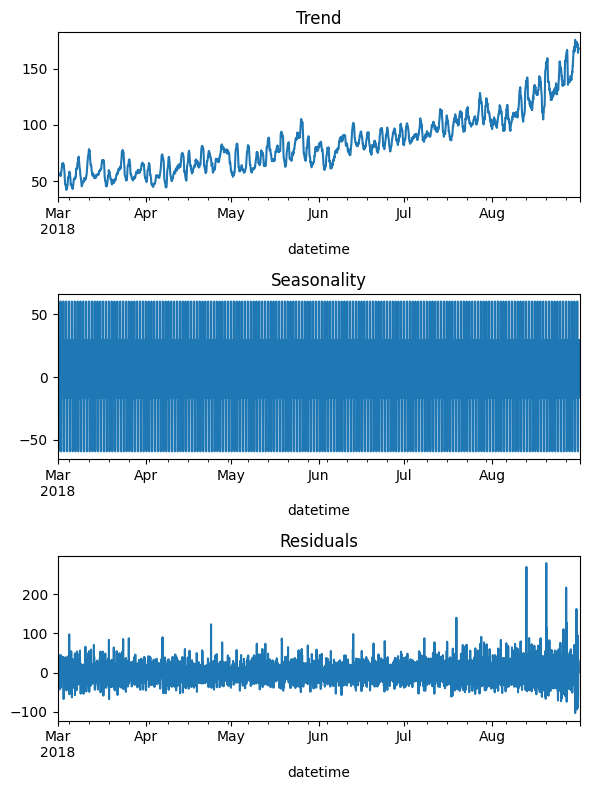

In [7]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Text(0.5, 1.0, 'Seasonality')

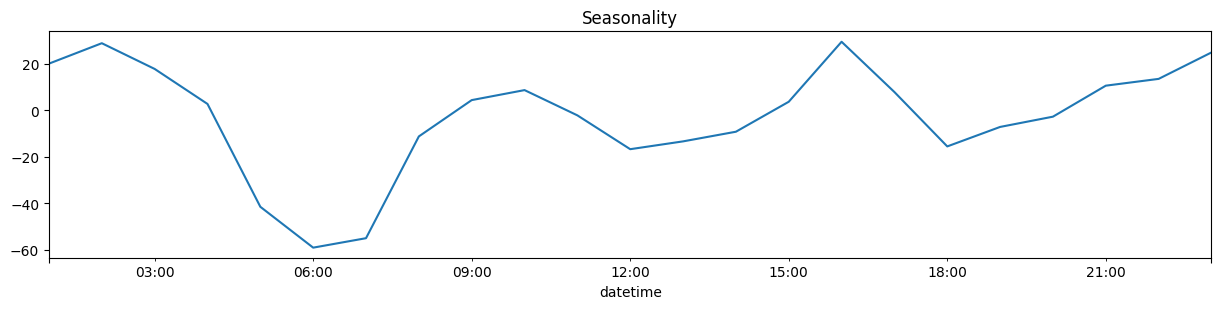

In [8]:
#seasonality from 24 hours
plt.subplot(312)
decomposed.seasonal[1:24].plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Seasonality')

Taxi orders seem to be fairly high around 9 in the morning probably for being going to work, then go down throughout the workday until about 4 or 5 in the afternoon. This could be for people leaving work. They then go back up throughout the night this could be for poeple going out for the 'night life'.

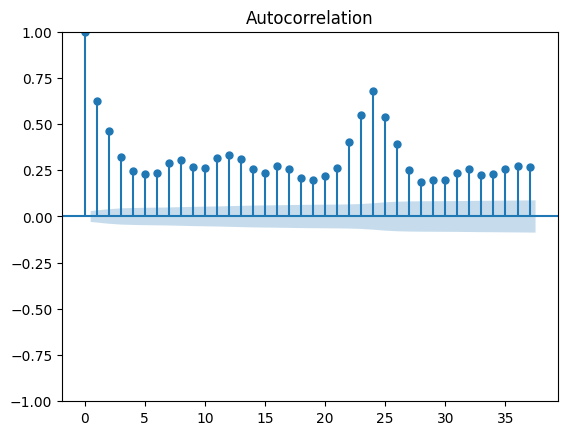

In [9]:
# check out the autocorrelation and partial autocorrelation
plot_acf(df.values)
plt.show()

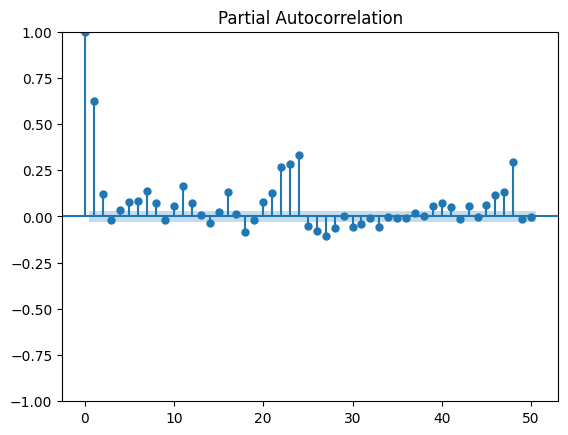

In [10]:
plot_pacf(df.values, lags=50)
plt.show()

In [11]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values", alpha=0.5)
    plt.legend(loc="upper left")
    plt.grid(True)

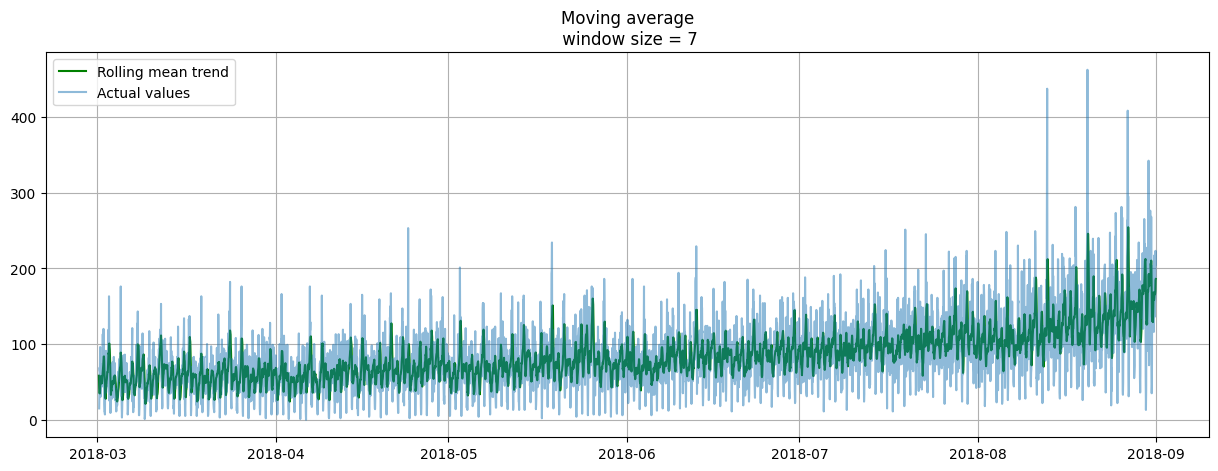

In [12]:
#plot moving average
plotMovingAverage(df, 7)

In [13]:
#stationarity test
# < 0.05 = stationary
# > 0.05 = nonstationary
df_stationarityTest = adfuller(df)
print("P-value: ", df_stationarityTest[1])

P-value:  0.028940051402613028


P-values showed that the data is stationary, no changes need to be made.

## Training

In [14]:
# make features
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek_num'] = df.index.dayofweek
df['hour'] = df.index.hour

for lag in range(1, 4):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

df['rolling_mean'] = df['num_orders'].shift().rolling(10).mean()

In [15]:
df.head(15)

,num_orders,month,day,dayofweek_num,hour,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,NaN
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,NaN


In [16]:
df = df.dropna()
df.head()

,num_orders,month,day,dayofweek_num,hour,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,52.5
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,46.5
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,47.6
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,43.5
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,40.1


In [17]:
def rmse(true, pred):
    return mean_squared_error(true, pred)**0.5

In [18]:
# split data for training, validation and test sets
train, test = train_test_split(df, shuffle=False, test_size=0.1)
x_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
x_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

### Linear Regression

In [19]:
lr = LinearRegression()
lr.fit(x_train, y_train)

pred_train = lr.predict(x_train)

### Random Forest

In [20]:
rf = RandomForestRegressor(random_state=123)
params = {
    'n_estimators': [10, 25, 50], 'max_depth': [15, 20]
}

tscv = TimeSeriesSplit()
gs = GridSearchCV(estimator=rf, cv=tscv, param_grid=params, scoring='neg_root_mean_squared_error')
gs.fit(x_train, y_train)
print('Best Params:\n', gs.best_params_)
       

Best Params:
 {'max_depth': 20, 'n_estimators': 50}


### ARIMA

In [21]:
res = arma_order_select_ic(y=train['num_orders'], max_ar=10, max_ma=10)
ma_order = res.bic_min_order[1]
ar_order = res.bic_min_order[0]

arima_model = ARIMA(train['num_orders'], order=(ar_order, 0, ma_order))
model_fit = arima_model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                 3965
Model:               ARIMA(10, 0, 10)   Log Likelihood              -18965.499
Date:                Thu, 13 Mar 2025   AIC                          37974.999
Time:                        10:49:58   BIC                          38113.274
Sample:                    03-01-2018   HQIC                         38024.036
                         - 08-13-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.3637     31.222      2.510      0.012      17.171     139.557
ar.L1         -0.1798      0.052     -3.456      0.001      -0.282      -0.078
ar.L2          0.4302      0.047      9.172      0.0

## Testing

### Linear Regression

In [22]:
pred_test = lr.predict(x_test)
print("RMSE test:", rmse(y_test, pred_test))

RMSE test: 53.96503029631335


### Random Forest

In [23]:
pred_test = gs.predict(x_test)
print("RMSE test:", rmse(y_test, pred_test))

RMSE test: 47.448114983475854


### ARIMA

In [22]:
arima_model = ARIMA(train['num_orders'], order=(10,0,10))
model_fit = arima_model.fit()
forecast = model_fit.forecast(steps=len(test))
forecast = forecast[:len(test)]
test_close = test["num_orders"][:len(forecast)]
print("RMSE test:", rmse(test_close, forecast))

RMSE test: 61.22052049880088


## Conclusion

The data on taxi orders was  first prepared and viewed for analysis and model building. Data was resampled to every hour to build models that can predict orders for the next hour. The data was analyzed through different graphs such as trends, seasonality, ACF and PACF, and moving average. To prepare for model training the data was determined to already be stationary. More features were also made for model prediction. Random Forest and ARIMA models were trained and tested. Linear Regression was also trained and tested more as a sanity check. The Random Forest model provided the best results fitting the necassary criterion with an RMSE of 47.4. The Random Forest model would be the best choice for predicting taxi sales for the next hour.